In [256]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [257]:
image_dir = '/Users/shreyasmishra/Documents/MLCode/CV/Project Task 1/train_data'
label_file = '/Users/shreyasmishra/Documents/MLCode/CV/Project Task 1/train_labels.txt'

In [258]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, label_file, num_classes = 60, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.num_classes = num_classes
        self.image_filenames = [f for f in sorted(os.listdir(image_dir)) if f.endswith('.jpg')]  
        self.labels = self.load_labels(label_file)
    
    def load_labels(self, label_file):
        with open(label_file, 'r') as f:
            labels = [int(line.strip()) for line in f]  
        return labels

    def one_hot_encode(self, label):
        # One-hot encode the label
        return torch.nn.functional.one_hot(torch.tensor(label), num_classes=self.num_classes)
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label = self.labels[idx]
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        one_hot_label = self.one_hot_encode(label - 1)
        
        return image, one_hot_label

In [259]:
dataset = ImageDataset(image_dir=image_dir, label_file=label_file, num_classes=60, transform=transforms.ToTensor())


In [260]:
all_images = []
all_labels = []
for img, label in dataset:
    all_images.append(img.numpy().flatten())  # Flatten 256x256 image to 1D array
    all_labels.append(torch.argmax(label).item()) 

all_images = np.array(all_images)
all_labels = np.array(all_labels)

X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)


In [261]:
pca = PCA(n_components=100)  # Reduce to 100 principal components
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Convert to PyTorch tensors
X_train_pca = torch.tensor(X_train_pca, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val_pca = torch.tensor(X_val_pca, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

In [262]:
train_dataset = torch.utils.data.TensorDataset(X_train_pca, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val_pca, y_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [263]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Fully connected layer 1
        self.fc2 = nn.Linear(128, 64)        # Fully connected layer 2
        self.fc3 = nn.Linear(64, output_dim) # Output layer
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))  # ReLU after first linear layer
        x = self.relu(self.fc2(x))  # ReLU after second linear layer
        x = self.fc3(x)             # No activation for the final layer
        return x

In [264]:
input_dim = 100  # Number of PCA components
output_dim = len(np.unique(all_labels))  # Number of classes (60 in this case)
model = ANN(input_dim, output_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)


In [265]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Clear gradients
            
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            running_train_loss += loss.item()
            
            # Accuracy calculation for training
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Compute average train loss and accuracy
        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                
                # Accuracy calculation for validation
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        # Compute average validation loss and accuracy
        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, '
              f'Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, epochs)


Epoch 1/20, Train Loss: 3.7594, Train Acc: 9.29%, Val Acc: 16.67%
Epoch 2/20, Train Loss: 2.9372, Train Acc: 21.17%, Val Acc: 23.83%
Epoch 3/20, Train Loss: 2.4855, Train Acc: 31.33%, Val Acc: 26.50%
Epoch 4/20, Train Loss: 2.1943, Train Acc: 39.12%, Val Acc: 29.00%
Epoch 5/20, Train Loss: 1.9265, Train Acc: 45.38%, Val Acc: 30.17%
Epoch 6/20, Train Loss: 1.6999, Train Acc: 52.08%, Val Acc: 33.50%
Epoch 7/20, Train Loss: 1.4712, Train Acc: 57.46%, Val Acc: 32.67%
Epoch 8/20, Train Loss: 1.3035, Train Acc: 61.50%, Val Acc: 32.83%
Epoch 9/20, Train Loss: 1.1077, Train Acc: 67.21%, Val Acc: 30.67%
Epoch 10/20, Train Loss: 0.9712, Train Acc: 71.17%, Val Acc: 32.83%
Epoch 11/20, Train Loss: 0.8245, Train Acc: 75.04%, Val Acc: 31.17%
Epoch 12/20, Train Loss: 0.6598, Train Acc: 81.71%, Val Acc: 30.67%
Epoch 13/20, Train Loss: 0.5782, Train Acc: 83.04%, Val Acc: 31.00%
Epoch 14/20, Train Loss: 0.4480, Train Acc: 87.71%, Val Acc: 31.17%
Epoch 15/20, Train Loss: 0.3456, Train Acc: 91.92%, Val Ac

In [266]:
torch.save(model.state_dict(), "/Users/shreyasmishra/Documents/new_model.pt")

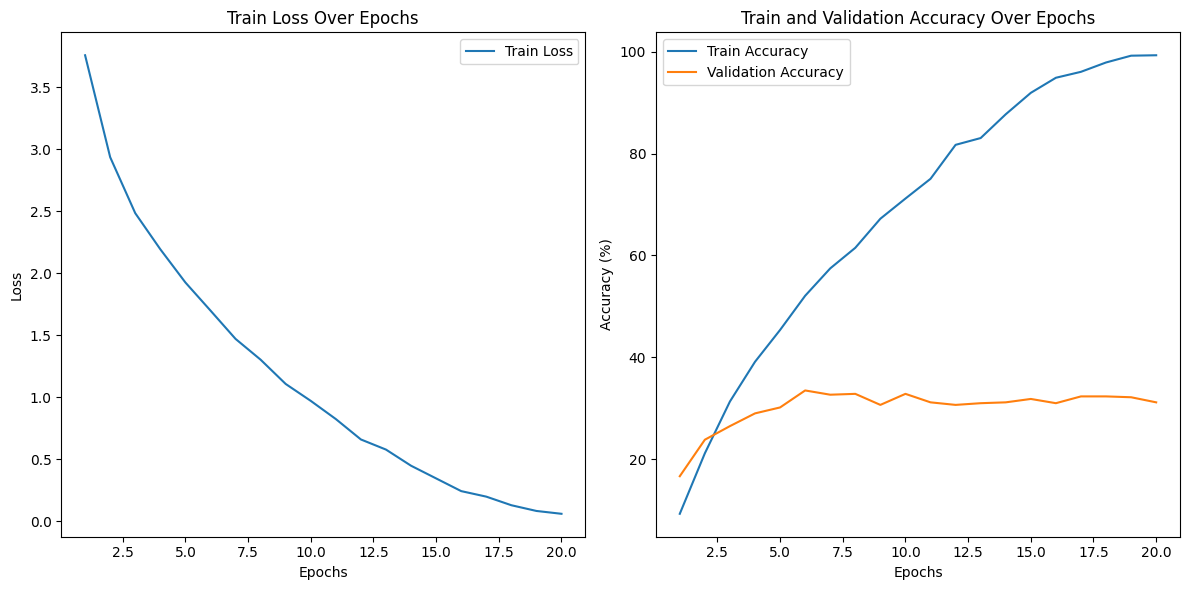

In [267]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

The following cells are for the classification of the test images. The only input required is the absolute file path of the image.

In [268]:
def load_and_preprocess_image(image_path, pca, transform):
    
    image = Image.open(image_path).convert("RGB")
    
    image_tensor = transform(image).unsqueeze(0)  

    image_flattened = image_tensor.view(-1).numpy().reshape(1, -1)

    image_pca = pca.transform(image_flattened)
    
    image_pca_tensor = torch.tensor(image_pca, dtype=torch.float32)
    
    return image_pca_tensor

In [269]:
def classify_image(model, image_pca_tensor):
    model.eval()
    
    with torch.no_grad():
        output = model(image_pca_tensor)
        
        _, predicted_class = torch.max(output, 1)
    
    return predicted_class.item() + 1

In [ ]:
transform = transforms.ToTensor()

test_image_path = " " #Add the absolute image file path here.

image_pca_tensor = load_and_preprocess_image(test_image_path, pca, transform)
predicted_class = classify_image(model, image_pca_tensor)

print(f"The predicted class for the image is: {predicted_class}")
